In [26]:
import numpy as np
import os
from helpers import *
from helpers_perso import *
from nan_imputation import *
from one_hot_encoding import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [2]:
data_path = os.path.join(os.getcwd(), "data", "dataset")
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path)
print("Data loaded successfully!")


Data loaded successfully!


## Handling columns containing Nan

Proportion of Nan values in Nan-containing values

Total number of columns plotted: 321
Number of columns containing NaN values: 239


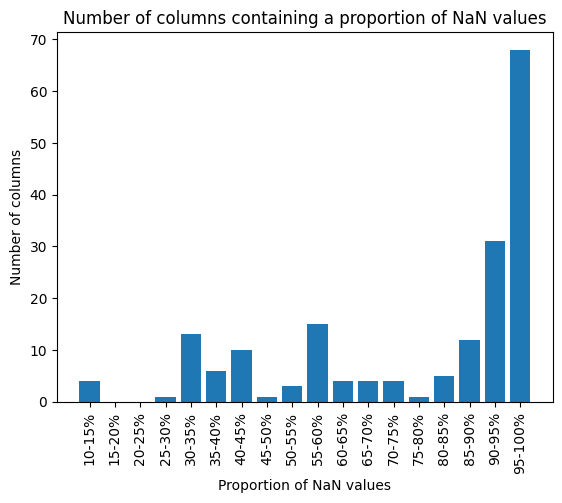

In [3]:
import matplotlib.pyplot as plt

# Calculate the proportion of NaN values in each column
nan_proportions = np.isnan(x_train).mean(axis=0)

# Print the total number of columns plotted
total_columns = nan_proportions.size
print(f"Total number of columns plotted: {total_columns}")

# Print the number of columns containing NaN values
num_columns_with_nans = np.sum(nan_proportions > 0)
print(f"Number of columns containing NaN values: {num_columns_with_nans}")

# Define the bins for the histogram
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

# Calculate the histogram
hist, bin_edges = np.histogram(nan_proportions, bins=bins)

# Create the bar plot
plt.bar(range(len(hist)), hist, tick_label=[f'{int(b*100)}-{int(bins[i+1]*100)}%' for i, b in enumerate(bins[:-1])])
plt.xlabel('Proportion of NaN values')
plt.ylabel('Number of columns')
plt.title('Number of columns containing a proportion of NaN values')

# Rotate the x-axis tick labels to vertical
plt.xticks(rotation=90)

plt.show()

Thus not reasonnable to exclude columns containing Nan values
Choice : remove columns with Nan proportion superior to 80 % ?

In [4]:
# Clean all arrays by removing columns containing NaN values
x_train_cleaned = remove_nan_features(x_train, 0.8)

Percentage of columns to delete (NaN proportion superior to 80.0 %): 36.14%
Data cleaned successfully!
Original shape of x_train: (328135, 321)
Cleaned shape of x_train: (328135, 205)


In [22]:
# Identify columns that only contain integers
integer_columns = [
        i for i in range(x_train_cleaned.shape[1])
        if np.all(np.mod(x_train_cleaned[:, i][~np.isnan(x_train_cleaned[:, i])], 1) == 0)
    ]

# Print the integer columns
print(f"Number of columns containing only integer values: {len(integer_columns)}")

# Count the number of columns in integer_columns that contain at least one zero
num_columns_with_zero = sum(np.any(x_train_cleaned[:, col] == 0) for col in integer_columns)

# Print the result
print(f"Percentage of integer columns that contain at least one zero: {num_columns_with_zero/len(integer_columns)*100:.2f}%")    

Number of columns containing only integer values: 182
Percentage of integer columns that contain at least one zero: 63.74%


(If only contains integers and no zeroes (=encoded), encode Nan as 0)

In [33]:
x_train_cleaned_without_nans = encode_nan_integer_columns(x_train_cleaned, replacement_value='mode')
x_train_cleaned_without_nans = encode_nan_continuous_columns(x_train_cleaned_without_nans, replacement_value='zero')

assert np.isnan(x_train_cleaned_without_nans).sum() == 0

Column 107 has been encoded with NaNs as 0
Column 108 has been encoded with NaNs as 0
Column 109 has been encoded with NaNs as 0
Column 112 has been encoded with NaNs as 0
Column 113 has been encoded with NaNs as 0
Column 135 has been encoded with NaNs as 0
Column 136 has been encoded with NaNs as 0
Column 137 has been encoded with NaNs as 0
Column 150 has been encoded with NaNs as 0
Column 151 has been encoded with NaNs as 0
Column 152 has been encoded with NaNs as 0
Column 153 has been encoded with NaNs as 0
Column 154 has been encoded with NaNs as 0
Column 155 has been encoded with NaNs as 0
Column 160 has been encoded with NaNs as 0
Column 161 has been encoded with NaNs as 0
Column 169 has been encoded with NaNs as 0
Column 170 has been encoded with NaNs as 0
Column 171 has been encoded with NaNs as 0
Column 172 has been encoded with NaNs as 0
Column 177 has been encoded with NaNs as 0
Column 178 has been encoded with NaNs as 0
Column 181 has been encoded with NaNs as 0
Number of c

In [25]:
# Calculate the number of columns that do not contain only integer values
num_non_integer_columns = x_train_cleaned.shape[1] - len(integer_columns)

# Print the result
print(f"Number of columns that do not contain only integer values: {num_non_integer_columns}")

Number of columns that do not contain only integer values: 23


## One-hot encoding

In columns containing only integer values, number of unique values

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of unique values for each integer-only column
unique_value_counts = np.array([len(np.unique(x_train_cleaned[:, col])) for col in integer_columns])

# Create 20 bins based on the range of unique value counts
max_unique = unique_value_counts.max() if unique_value_counts.size > 0 else 0
bins = np.linspace(0, max_unique, 21)  # 21 edges for 20 bins
bin_labels = [f'{int(b)}-{int(bins[i+1])}' for i, b in enumerate(bins[:-1])]

# Count how many columns fall into each bin
binned_counts = np.histogram(unique_value_counts, bins=bins)[0]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, binned_counts, width=0.6, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Unique Values in Columns')
plt.ylabel('Number of Columns')
plt.title('Columns Grouped by Number of Unique Values (20 Bins)')
plt.xticks(rotation=45)
plt.tight_layout()
# Create the second set of bins for values between 2000 and 0
bins_2000 = np.linspace(0, 2000, 21)  # 21 edges for 20 bins
bin_labels_2000 = [f'{int(b)}-{int(bins_2000[i+1])}' for i, b in enumerate(bins_2000[:-1])]

# Count how many columns fall into each bin for the second set of bins
binned_counts_2000 = np.histogram(unique_value_counts, bins=bins_2000)[0]

# Create the second bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels_2000, binned_counts_2000, width=0.6, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Unique Values in Columns (0-2000)')
plt.ylabel('Number of Columns')
plt.title('Columns Grouped by Number of Unique Values (20 Bins, 0-2000)')
plt.xticks(rotation=45)
plt.tight_layout()

# Create the third set of bins for values between 0 and 100
bins_100 = np.linspace(0, 100, 21)  # 21 edges for 20 bins
bin_labels_100 = [f'{int(b)}-{int(bins_100[i+1])}' for i, b in enumerate(bins_100[:-1])]

# Count how many columns fall into each bin for the third set of bins
binned_counts_100 = np.histogram(unique_value_counts, bins=bins_100)[0]

# Create the third bar plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels_100, binned_counts_100, width=0.6, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Unique Values in Columns (0-100)')
plt.ylabel('Number of Columns')
plt.title('Columns Grouped by Number of Unique Values (20 Bins, 0-100)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


In [ ]:
# columns_to_encode = range(0,6)
# for column in columns_to_encode:
#     x_train_cleaned_encoded = one_hot_encode_column(x_train_cleaned, column)
# print(f"Columns {[col + 1 for col in columns_to_encode]} one-hot encoded successfully!")